# PyTorch Custom Datasets.

How do you get your own data into PyTorch ?

Depending on the type of data, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Import PyTorch and set up device agnostic code

In [72]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Food101 reduced to 3 classes and 10% of the images.

Good to start with a reduced data set to experiment and generalize when we're good.

In [73]:
import requests
import zipfile
from pathlib import Path

data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f'{image_path} directory already exist (skip)')
else :
  print(f'{image_path} does not exist, creating')
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip',"wb") as f :
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref :
  print("Unzipping database")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exist (skip)
Downloading
Unzipping database


## 2. Becoming one with data :

In [74]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents."""
  for dirpath,dirnames,filenames in os.walk(dir_path) :
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [75]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [76]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image :

data/pizza_steak_sushi/test/pizza/309892.jpg
pizza
random image path : data/pizza_steak_sushi/test/pizza/309892.jpg
image class: pizza
image height :333
image width : 512


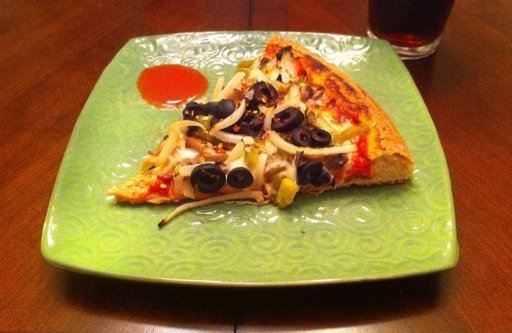

In [77]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Get image paths
image_path_list=list(image_path.glob('*/*/*.jpg')) #Regex ??

# Pick a random image path
random_image_path=random.choice(image_path_list)
print(random_image_path)

# Get image class from path name (name of dir where image is stored) :
image_class=random_image_path.parent.stem
print(image_class)

# Open iamge
img=Image.open(random_image_path)

# Print metadata :
print(f'random image path : {random_image_path}')
print(f'image class: {image_class}')
print(f'image height :{img.height}')
print(f'image width : {img.width}')
img

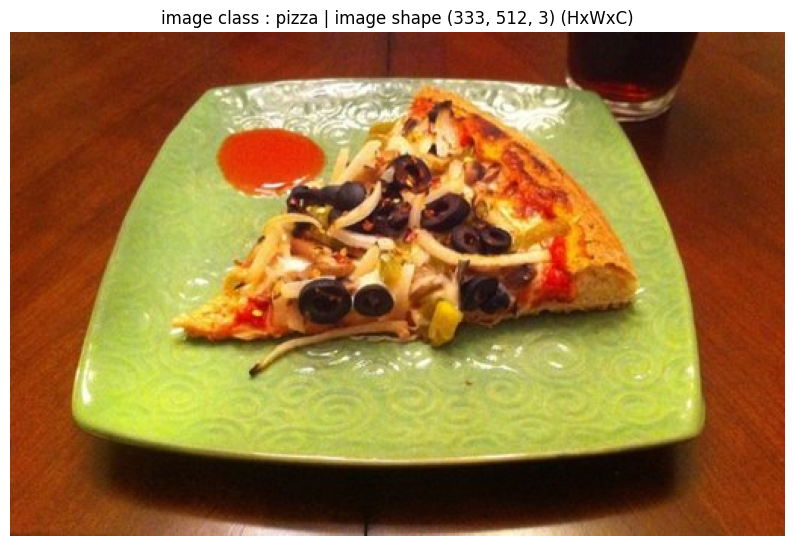

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot the img :
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'image class : {image_class} | image shape {img_as_array.shape} (HxWxC)')
plt.axis(False);

array([[[119,  55,  20],
        [121,  57,  22],
        [119,  55,  19],
        ...,
        [128,  60,  21],
        [138,  69,  28],
        [137,  65,  25]],

       [[114,  50,  15],
        [113,  49,  14],
        [113,  49,  14],
        ...,
        [130,  62,  23],
        [136,  67,  26],
        [139,  67,  27]],

       [[119,  54,  22],
        [114,  50,  15],
        [115,  51,  16],
        ...,
        [131,  66,  26],
        [132,  63,  22],
        [139,  67,  27]],

       ...,

       [[143,  58,  19],
        [139,  54,  15],
        [143,  55,  17],
        ...,
        [139,  51,   5],
        [139,  48,   4],
        [142,  53,   9]],

       [[128,  46,   9],
        [127,  45,   7],
        [131,  47,  10],
        ...,
        [142,  56,   9],
        [137,  48,   4],
        [140,  53,   8]],

       [[112,  34,   0],
        [117,  39,   1],
        [124,  44,   7],
        ...,
        [142,  58,  11],
        [137,  50,   5],
        [139,  55,   9]]], dtype=uint8)
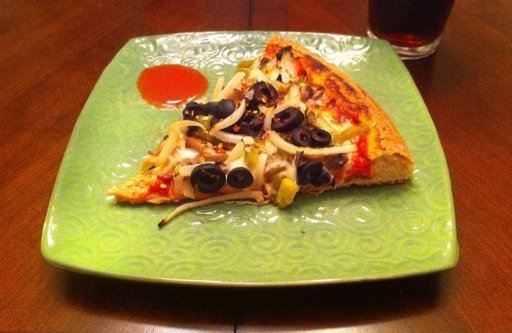

In [79]:
img_as_array

## 3. Transforming data :


In [80]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [81]:
# Write a transform for image :
data_transform = transforms.Compose([
    # Resize image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the image horizontaly randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image to tensors :
    transforms.ToTensor()
])

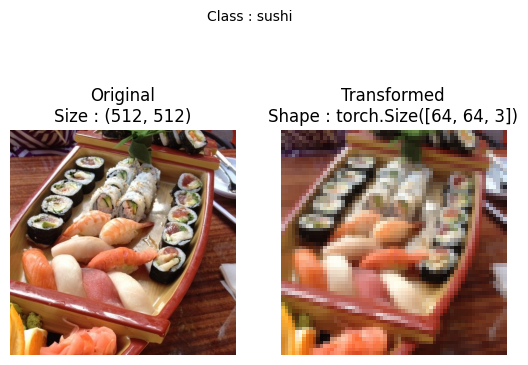

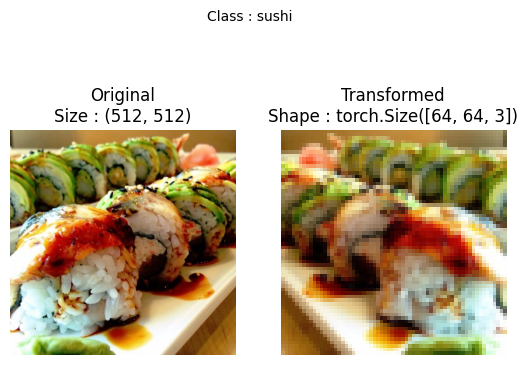

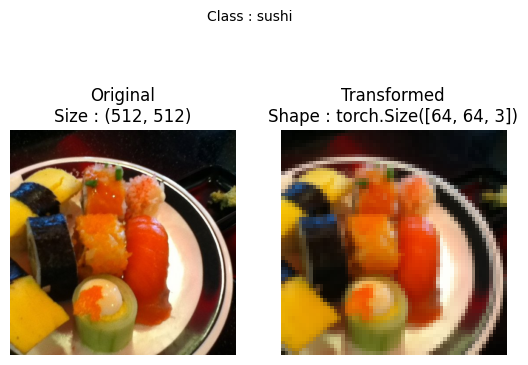

In [82]:
def plot_transformed_images(image_paths,transform,n=3,seed=42) :
  """
  Selects random img from a path of images and loads/transforms them
  then plot the orignal vs transformed iamges
  """
  if seed :
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths :
    with Image.open(image_path) as f :
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize : {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image=transform(f).permute(1,2,0) # C,H,W -> H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape : {transformed_image.shape}')
      ax[1].axis("off")

      fig.suptitle(f'Class : {image_path.parent.stem}', fontsize=10)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1 : Loading image data using ImageFolder

We can load image classification data using 'torchvision.datasets.ImageFolder'

In [83]:
# Use ImageFolderto create dataset(s)

from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # Transform data
                                target_transform=None) # Transform target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [84]:
# Get class names as list :
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [85]:
# Get class names as dict :
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [86]:
# Check length of our dataset :
len(train_data), len(test_data)

(225, 75)

In [87]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [88]:
# Index on the train_data Dataset to get a single image and label :
img,label=train_data[0][0],train_data[0][1]
print(f'Image tensor :\n{img}')
print(f'Iamge shape : {img.shape}')
print(f'Image datatype : {img.dtype}')
print(f'Image label : {label}')
print(f'label dtype : {type(label)}')

Image tensor :
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape :torch.Size([3, 64, 64]) -> C,H,W
New shape : torch.Size([64, 64, 3]) -> H,W,C


Text(0.5, 1.0, 'pizza')

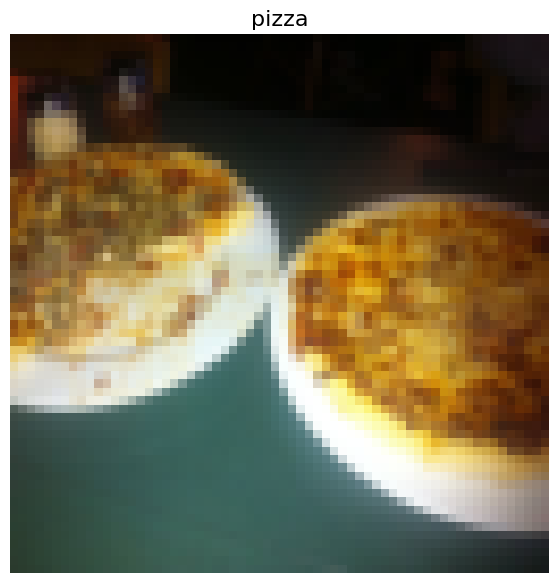

In [89]:
# Rearrange the ordre dimensions :
img_permute=img.permute(1,2,0)

# Print out different shapes :
print(f'Original shape :{img.shape} -> C,H,W' )
print(f'New shape : {img_permute.shape} -> H,W,C')

# Plot image:
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=16)

## 4.1 Turn loaded images into DataLoader :


In [90]:
import os
os.cpu_count() # Nombre de cpu usuable

2

In [91]:
# Turn train and test datasets into DataLoader :
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=1,
                           shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dc5d10cfc40>,
 <torch.utils.data.dataloader.DataLoader at 0x7dc5d10cfe50>)

In [92]:
len(train_dataloader), len(test_dataloader) # Number of batches

(225, 75)

In [93]:
len(train_data), len(test_data)

(225, 75)

In [94]:
img, label=next(iter(train_dataloader))

# Batch size will now be 1 (changeable si on veut)
print(f'Image shape : {img.shape} -> [batch_size,C,H,W]')
print(f'Label shape : {label.shape}')

Image shape : torch.Size([1, 3, 64, 64]) -> [batch_size,C,H,W]
Label shape : torch.Size([1])


## 5. Option 2 : Loading image data with custom Dataset

1. Be able to load image from file
2. Be able to get class names from dataset
3. Be able to get class dict from dataset

Pros :
* Can create Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset function

Cons :
* Even though you could create Dataset out of almost anything it doesen't mean it will work
* Using custom Dataset often reuslts in us writing more codewhich could be prone to errors or perf issues


In [95]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [96]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper func to get class names :

1. Get the class names using os.scandir() to traverse a target dir (ideally the dir is in standard img classification format)
2. Raise an error if th eclass name aren't found
3. Turn the class names int o a dict and a list and return them


In [97]:
# Setup path for target dir
target_directory= train_dir
print(f'Target dir : {target_directory}')

# Get the class names from the target dir :
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found #list of class names

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [98]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [99]:
def find_classes(directory : str ) -> Tuple[List[str], Dict[str,int]] :
  """ Finds the class folder names in a target dir """
  # 1. Get class names by scanning target dir
  classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise error if class names could not be found
  if not classes :
    raise FileNotFoundError(f"Couldn't find any classes in {directory} please check file struct")

  # 3. Create dict of index label :
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [100]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create custom Dataset to replicate ImageFolder :

1. Subclass 'torch.utils.data.Dataset'
2. Init our subclass with a target dir (the dir we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes :
  * paths - paths of our images
  * transform
  * classes
  * class_to_idx
4. Create a function to 'load_images()' to open an image
5. Overwrite the '__len()__' methode to return the length of our dataset
6. Overwrite the '__getitem()__' method to return a given sample when passed an index

In [101]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None) -> None :
    # 3. Create class atributes
    # Get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #Setup transforms:
    self.transform=transform
    # Create classes and class_to_idx attributes:
    self.classes, self.class_to_idx = find_classes(targ_dir)
  # 4. Create func to load images :
  def load_image(self,index:int)-> Image.Image :
    "Open an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__ :
  def __len__(self) -> int :
    return len(self.paths)

  # 6. Overwrite __getitem__() :
  def __getitem__(self,index:int) -> Tuple[torch.Tensor, int] :
    "Returns one sample of data, data and label (X,y)"
    img=self.load_image(index)
    class_name=self.paths[index].parent.name # excepts path in format data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary :
    if self.transform :
      return self.transform(img), class_idx # Return data, label (X,y)
    else :
      return img, class_idx # Untransformed img and label

In [102]:
# Create a transform :
from torchvision import transforms
train_transforms= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
    ])

In [103]:
# Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transforms)

test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7dc5d10cf820>,
 <__main__.ImageFolderCustom at 0x7dc5d10cedd0>)

In [104]:
len(train_data), len(train_data_custom)

(225, 225)

In [105]:
len(test_data), len(test_data_custom)

(75, 75)

In [106]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [107]:
# Check for equality btw original ImageFolder dataset and ours
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a 'Dataset' and a number of other param such as class names and how many img to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. Set random seed
4. Get a list of random sample indexes from target dataset
5. Setup a matplotlib plot
6. Loop through the random sample sample and plot them with matplotlib
7. Make sure the dim of our image line up with matplotlib (HWC)

In [108]:
# 1. Create a func to take in a dataset
def display_random_images(dataset:  torch.utils.data.Dataset,
                          classes : List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None) :
  # 2. Adjust display if n is too high :
  if n>10 :
    n=10
    display_shape=False
    print(f"For display purposes, n shouldn't be larget than 10, setting to 10")

  #3. Set seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes :
  random_samples_idx=random.sample(range(len(dataset)),k=n)

  #5. Setup plot :
  plt.figure (figsize=(16,8))

  # 6. loop through random indx andp lot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx) :
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    # 7. Adjust tensor dim for plotting :
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted smapels :
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes :
      title=f"Class : {classes[targ_label]}"
      if display_shape :
        title = title + f"\n shape :{targ_image_adjust.shape}"
      plt.title(title)

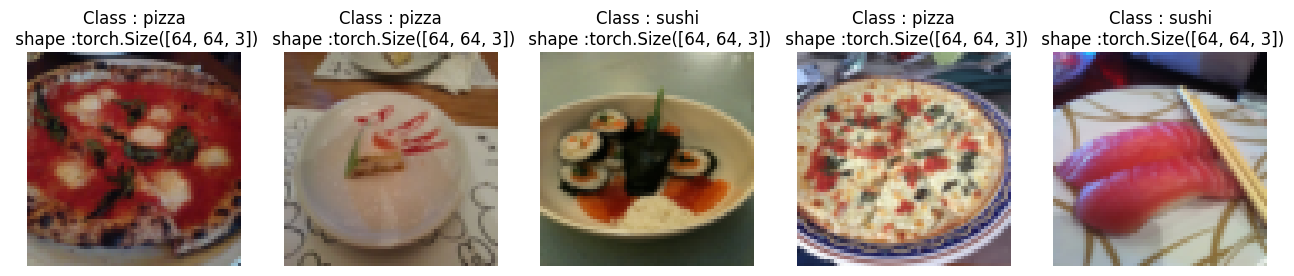

In [109]:
# Diplay random iamge from the ImageFolder
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

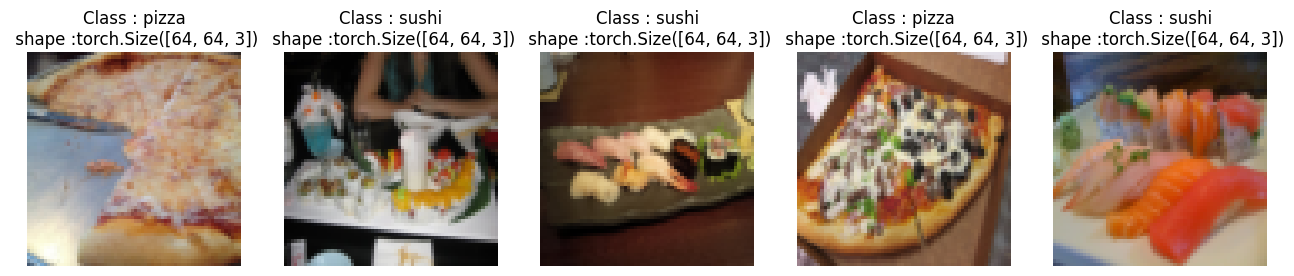

In [110]:
# Display random images from the ImageFolderCustom Dataset :
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom data laoded images into DataLoader's  

In [111]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader_custom=DataLoader(dataset=train_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=0,
                                   shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                  batch_size=BATCH_SIZE,
                                  num_workers=0,
                                  shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7dc5b4d8ec50>,
 <torch.utils.data.dataloader.DataLoader at 0x7dc5d0e59a80>)

In [112]:
# Get a sample :
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Process of artificially adding diversity to your training data.

In case of image, mean applying various image transformation to training images.

This practice hopefully result in a more generalizable model.

In [113]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [114]:
# Get all iamge paths :
image_path_list=list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg')]

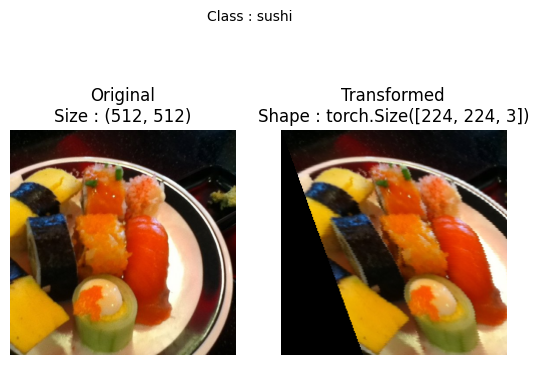

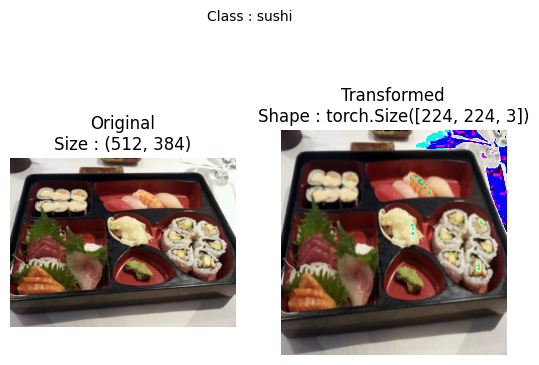

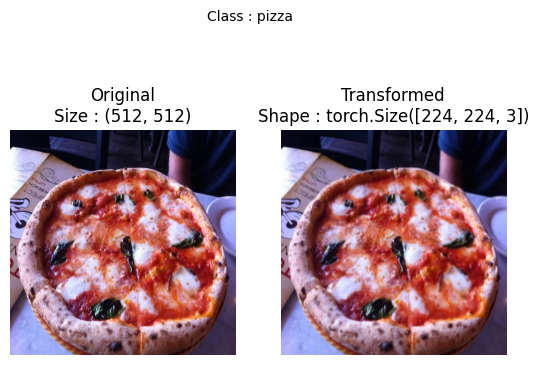

In [115]:
# Plot random transformed images :
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0 : TinyVGG without data augmentation


### 7.1 Creating transforms and loading data for model 0

In [116]:
# Create a simple transforms :
simple_transform= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [117]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn dataset into dataloader
import os
from torch.utils.data import DataLoader

BATCH_SIZE= 32
NUM_WORKERS=os.cpu_count()

# Create dataloader's
train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)

### 7.2 Create TinyVGG model class

In [118]:
class TinyVGG(nn.Module) :
  """ Model architecture copying TinyVGG from CNN Explainer"""
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int) -> None :
    super().__init__()
    self.conv_block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
        out_features=output_shape)
    )
  def forward(self,x) :
    x=self.conv_block1(x)
    #print(x.shape)
    x=self.conv_block2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x # return self.classifier(self.conv_block2(self.conv_block1(x))) # benfits from operator fusion



In [119]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [120]:
# Get a single image batch :
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [121]:
# Try a forward pass :
with torch.inference_mode():
  print(model_0(image_batch.to(device)))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get an idea of the shapes going through our model


In [122]:
# Install torchinfo, import if it's available
try :
  import torchinfo
except :
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [123]:
# Create train_step()

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  # Setup train loss and train acc values
  train_loss, train_acc=0,0

  # Loop through data laoder data batches
  for batch, (X,y) in enumerate(dataloader) :
    X,y = X.to(device), y.to(device)

    # Forward
    y_pred=model(X)

    # Calculate loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    # Zero grad
    optimizer.zero_grad()

    # Backward
    loss.backward()

    # Optimizer step :
    optimizer.step()

    # Calculate acc metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get avg per batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  return train_loss, train_acc

In [124]:
# Create test step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device) :
  model.eval()

  # Steup test_loss test acc
  test_loss, test_acc = 0,0

  #Turn on inference mdoe :
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader) :
      X,y=X.to(device), y.to(device)

      # Forward
      test_pred_logits = model(X)
      # Loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      # Acc
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=((test_pred_labels==y).sum().item()/len(test_pred_labels))

  #Adjust
  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc

### 7.6 Create train() func to combine train_step and test_step

In [125]:
from tqdm.auto import tqdm

# 1. Create a train func :
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device) :
  # Create empty result dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss" : [],
             "test_acc" :[]}

  # Loop through trian and test :
  for epoch in tqdm(range(epochs)) :
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

    # Print out :
    print(f'Epoch : {epoch} | Train loss: {train_loss:.4f} | Train_acc : {train_acc:.2f}% | Test_ loss {test_loss:.4f} | Test acc :{test_acc:.2f}%')

    # Update dict :
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


### 7.7 Train and evaluate model 0

In [126]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG :
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss and optim
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)

# Start timer:
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print how long it took :
end_time = timer()

print(f'Total training time : {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 | Train loss: 1.1063 | Train_acc : 0.30% | Test_ loss 1.0983 | Test acc :0.30%
Epoch : 1 | Train loss: 1.0998 | Train_acc : 0.33% | Test_ loss 1.0697 | Test acc :0.54%
Epoch : 2 | Train loss: 1.0869 | Train_acc : 0.49% | Test_ loss 1.0808 | Test acc :0.49%
Epoch : 3 | Train loss: 1.0842 | Train_acc : 0.40% | Test_ loss 1.0608 | Test acc :0.58%
Epoch : 4 | Train loss: 1.0662 | Train_acc : 0.41% | Test_ loss 1.0654 | Test acc :0.56%
Total training time : 20.867 seconds


In [127]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot loss curves of Model 0

In [128]:
# Get model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

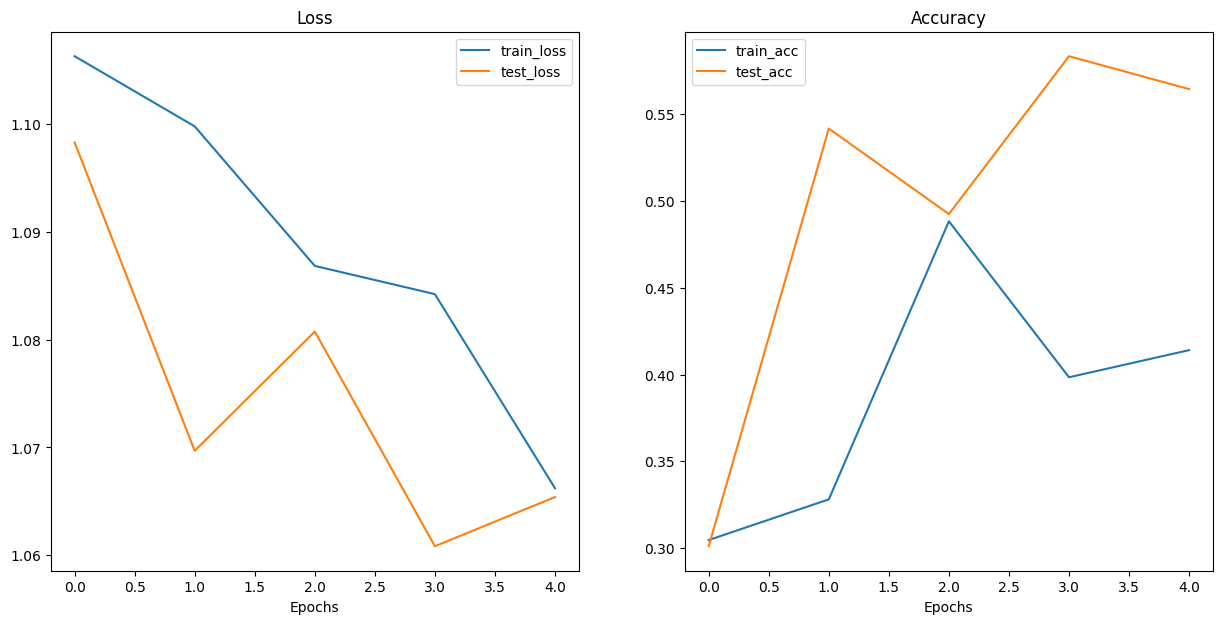

In [129]:
def plot_loss_curves(results:Dict[str,List[float]]) :
  """ Plot training curves of a reuslts dict """
  # Get loss values of results dict (trian and test)
  loss=results["train_loss"]
  test_loss=results['test_loss']

  # Get acc :
  accuracy = results['train_acc']
  test_acc = results['test_acc']

  # Figure out how many epoch there wre
  epochs=range(len(results["train_loss"]))

  # Setup plot :
  plt.figure(figsize=(15,7))

  # Plot loss :
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot acc :
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_acc')
  plt.plot(epochs, test_acc, label='test_acc')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(model_0_results)

## 9. Model 1 : TinyVGG with data augmentation

### 9.1 Create a transform with data augmentation

In [130]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset and DataLoader with data augmentation

In [131]:
# Turn image folders into Datasets :
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=test_transform_simple)

In [132]:
# Turn Datasets into DataLoaders :
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7dc5b5174ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dc5d0da72e0>)

### 9.3 Construct and train model 1

Same architecture but with data augmentation on trianing data

In [133]:
# Create model_1 and send it to the device
torch.manual_seed(42)
model_1=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [134]:
# Set random seed :
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs :
NUM_EPOCHS = 5

# Loss :
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

# Start timer :
from timeit import default_timer as timer
start_time=timer()

# Train model 1
model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

# End timer and print how long it took
end_time=timer()

print(f'Total time for training : {end_time-start_time:.2f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 | Train loss: 1.1049 | Train_acc : 0.25% | Test_ loss 1.1019 | Test acc :0.26%
Epoch : 1 | Train loss: 1.0807 | Train_acc : 0.43% | Test_ loss 1.1261 | Test acc :0.26%
Epoch : 2 | Train loss: 1.0712 | Train_acc : 0.43% | Test_ loss 1.1593 | Test acc :0.26%
Epoch : 3 | Train loss: 1.1253 | Train_acc : 0.30% | Test_ loss 1.1581 | Test acc :0.26%
Epoch : 4 | Train loss: 1.0865 | Train_acc : 0.43% | Test_ loss 1.1554 | Test acc :0.33%
Total time for training : 21.63 seconds


### 9.4 Plot the loss curves of model 1

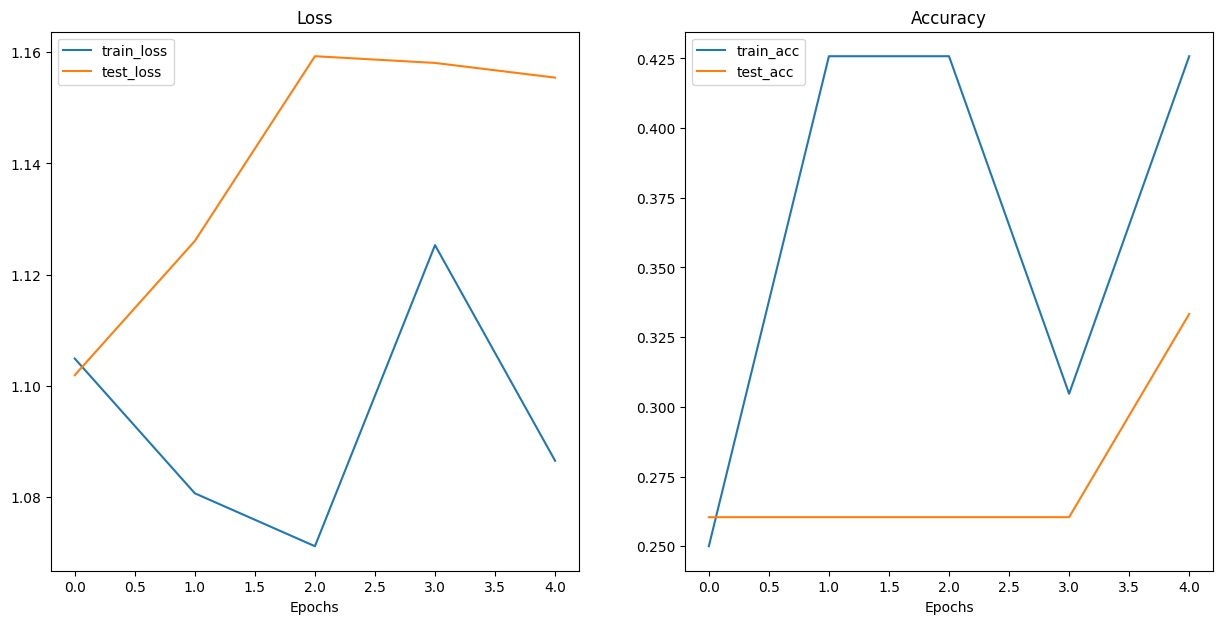

In [137]:
plot_loss_curves(model_1_results)

## 10. Compare model results

How to do it :
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard ()
3. Weights & bias
4. MLFlow

In [139]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.106319   0.304688   1.098321  0.301136
 1    1.099806   0.328125   1.069690  0.541667
 2    1.086854   0.488281   1.080757  0.492424
 3    1.084233   0.398438   1.060832  0.583333
 4    1.066216   0.414062   1.065396  0.564394,
    train_loss  train_acc  test_loss  test_acc
 0    1.104914   0.250000   1.101928  0.260417
 1    1.080687   0.425781   1.126056  0.260417
 2    1.071172   0.425781   1.159274  0.260417
 3    1.125309   0.304688   1.158067  0.260417
 4    1.086534   0.425781   1.155428  0.333333)

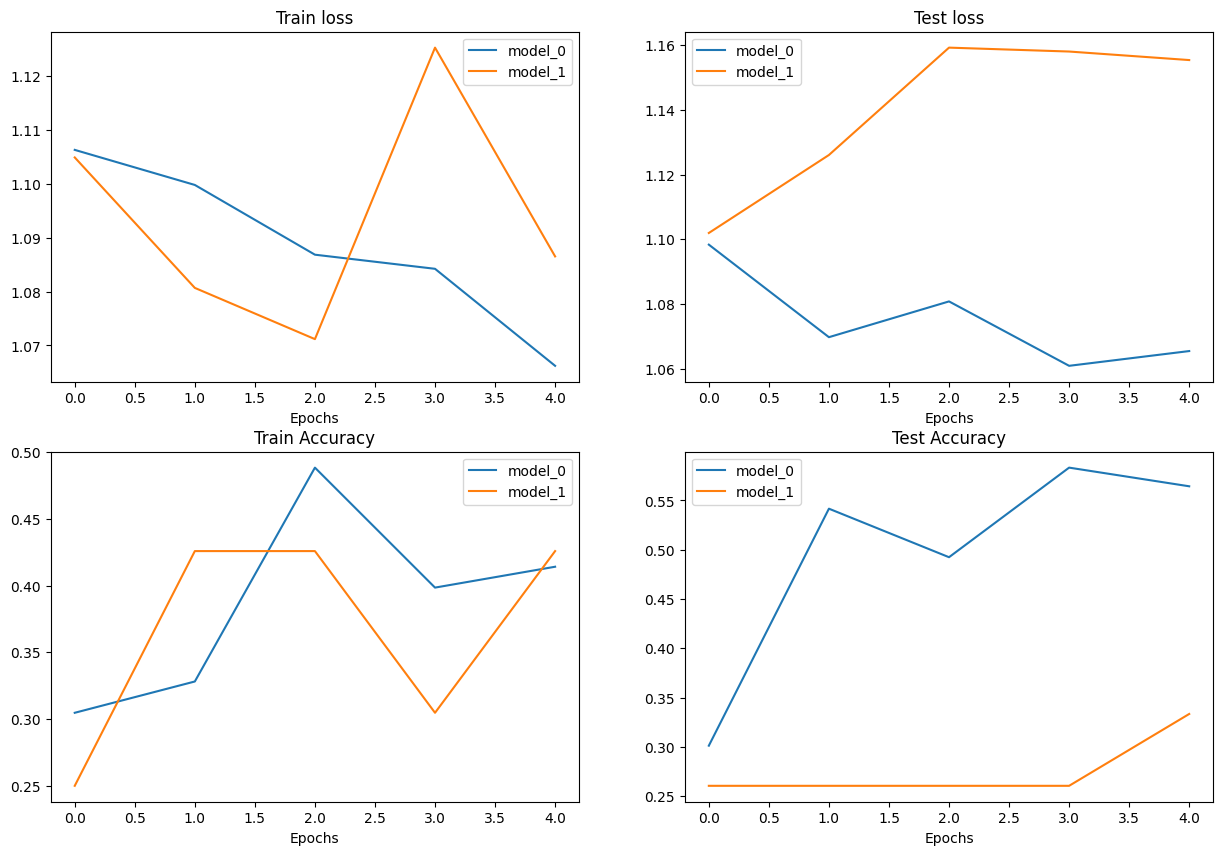

In [143]:
# Setup a plot
plt.figure(figsize=(15,10))

# Epochs
epochs=range(len(model_0_df))

# Plot for train loss :
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="model_0")
plt.plot(epochs,model_1_df["train_loss"],label="model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot for test loss :
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="model_0")
plt.plot(epochs,model_1_df["test_loss"],label="model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot for train accuracy :
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="model_0")
plt.plot(epochs,model_1_df["train_acc"],label="model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot for test acc :
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="model_0")
plt.plot(epochs,model_1_df["test_acc"],label="model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making pred on a custom image :


In [152]:
# Download a custom image
import requests

# Setup custom iamge path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Dowload image if it doesn't alraedy exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f :
    # When downloading from github we need raw link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else :
  print(f'{custom_image_path} already exist')

### 11.1 Loading custom image with PyTorch :

We have to make sure our custom image is in the same format as the data our model was trained on.

In [156]:
import torchvision

# Read in custom iamge:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image tensor\n : {custom_image_uint8}')
print(f'Custom image shape : {custom_image_uint8.shape}')
print(f'Custom image datatype : {custom_image_uint8.dtype}')

Custom image tensor
 : tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape : torch.Size([3, 4032, 3024])
Custom image ty

### 11.2 Making a pred on a custom image with a trained PyTorch model :

* Load the image and turn it into a tensor
* Make sure the image was the same dtype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as our model

In [161]:
# Load in custom image nad convert to torch.float32 and scale btw 0,1
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.

In [163]:
# Create transform pipeline to resize image:
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform targ img
custom_image_transformed = custom_image_transform(custom_image)

# Print shape:
print(custom_image.shape, custom_image_transformed.shape)

torch.Size([3, 4032, 3024]) torch.Size([3, 64, 64])


In [169]:
model_1.eval()
with torch.inference_mode() : # Unqueeze add a batch size dimension
  custom_image_pred= model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0780,  0.0379, -0.2067]])

In [171]:
# Convert logits -> prediction probabilities :
custom_image_pred_probs = torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [174]:
# Convert prediction probs -> prediction label :
custom_image_pred_labels= torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [173]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image pred together (building a function)

In [185]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device) :
  """ Makes a prediction on a target image with a trained model and plots the image and prediction"""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel value by 255 to get them btw 0,1
  target_image/=255.

  # Transform if necessary :
  if transform :
    target_image=transform(target_image)

  # Make sure the model is on the target device :
  model.to(device)

  # Turn eval & inference mode and make a pred :
  model.eval()
  with torch.inference_mode() :
    # Add and extra dim to the image (batchsize)
    target_image=target_image.unsqueeze(0)

    # Make a pred :
    target_image_pred = model(target_image.to(device))

  # Convert logits to pred probs :
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # Pred prob -> labels :
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  # Plot the image alongside the pred and pred prob :
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove extra dim and rearrange to HCW
  if class_names :
    title=f'Pred : {class_names[target_image_pred_label.cpu()]} | Prob : {target_image_pred_probs.max().cpu():.3f}'
  else :
    title = f'Pred : {target_image_pred_labels} | Prob : {target_image_pred_probs.max().cpu():.3f}'

  plt.title(title)
  plt.axis(False)

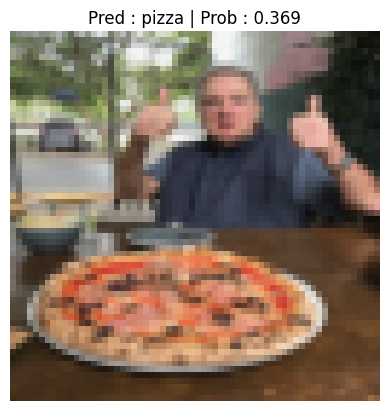

In [186]:
# Pred on our custom image :
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# Exercices :

https://www.learnpytorch.io/04_pytorch_custom_datasets/#exercises

Solution : https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb